In [59]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


from scellst.constant import METRICS_DIR
from scellst.metrics.metric_utils import format_metric_df
from scellst.utils import split_to_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
metrics_test = ["pcc", "scc"]

# Output
save_path = Path("figures/benchmark")
save_path.mkdir(exist_ok=True)

# 1. Benchmark all model metrics


In [61]:
list_models = ["istar", "HisToGene", "MclSTExp", "THItoGene"]

In [62]:
# Prepare paths
all_metrics_paths = []
for model in list_models:
    # Prepare paths
    metrics_dir = METRICS_DIR / model
    metrics_paths = list(metrics_dir.iterdir())
    print(f"Found {len(metrics_paths)} paths for model: {model}")
    all_metrics_paths.extend(metrics_paths)

Found 356 paths for model: istar
Found 712 paths for model: HisToGene
Found 712 paths for model: MclSTExp
Found 712 paths for model: THItoGene


In [63]:
# Add cellst metrics
metrics_dir = METRICS_DIR / "benchmark" / "mil"
metrics_paths = list(metrics_dir.iterdir())
print(f"Found {len(metrics_paths)} paths for cellst single slide")
all_metrics_paths.extend(metrics_paths)

metrics_dir = METRICS_DIR / "benchmark-multiple" / "mil"
metrics_paths = list(metrics_dir.iterdir())
print(f"Found {len(metrics_paths)} paths for cellst multiple slide")
all_metrics_paths.extend(metrics_paths)

Found 356 paths for cellst single slide
Found 356 paths for cellst multiple slide


In [64]:
# Load metrics
all_df = []
for path in tqdm(all_metrics_paths):
    if not path.exists():
        print(f"Path {path} does not exist")
        continue
    df = pd.read_csv(path, index_col=0)
    all_df.append(df)

# Concatenate all metrics
metrics = pd.concat(all_df).reset_index(drop=True)
metrics["tag"] = [path.stem for path in all_metrics_paths]
metrics = format_metric_df(metrics)

  0%|          | 0/3204 [00:00<?, ?it/s]

In [65]:
# Format metrics for plotting
df_hp = pd.DataFrame(metrics["tag"].apply(split_to_dict).to_list())
metrics = pd.concat([metrics, df_hp], axis=1)

list_hp = df_hp.columns.sort_values(ascending=True).tolist()
list_hp.remove("train_slide")
list_hp.remove("fold")
list_hp.remove("test_slide")
print(f"Found {list_hp} parameters.")

Found ['embedding_tag', 'genes', 'infer_mode', 'model'] parameters.


In [66]:
metrics["multislide_training"] = metrics["train_slide"].isna()
metrics["model"] = metrics["model"].fillna("sCellST")
metrics["organ"] = metrics["genes"].str.split("_").str[0]
metrics["genes"] = metrics["genes"].replace({
    "Kidney_50_hvg_bench": "50 HVG",
    "Kidney_50_svg_bench": "50 SVG",
    "Prostate_50_hvg_bench": "50 HVG",
    "Prostate_50_svg_bench": "50 SVG",
    "Kidney_500_hvg_bench": "500 HVG",
    "Kidney_500_svg_bench": "500 SVG",
    "Prostate_500_hvg_bench": "500 HVG",
    "Prostate_500_svg_bench": "500 SVG",
})

In [67]:
palette = sns.color_palette("magma", n_colors=len(metrics["model"].unique()))
palette = {model: color for model, color in zip(["HisToGene", "THItoGene", "istar", "MclSTExp", "sCellST"], palette)}

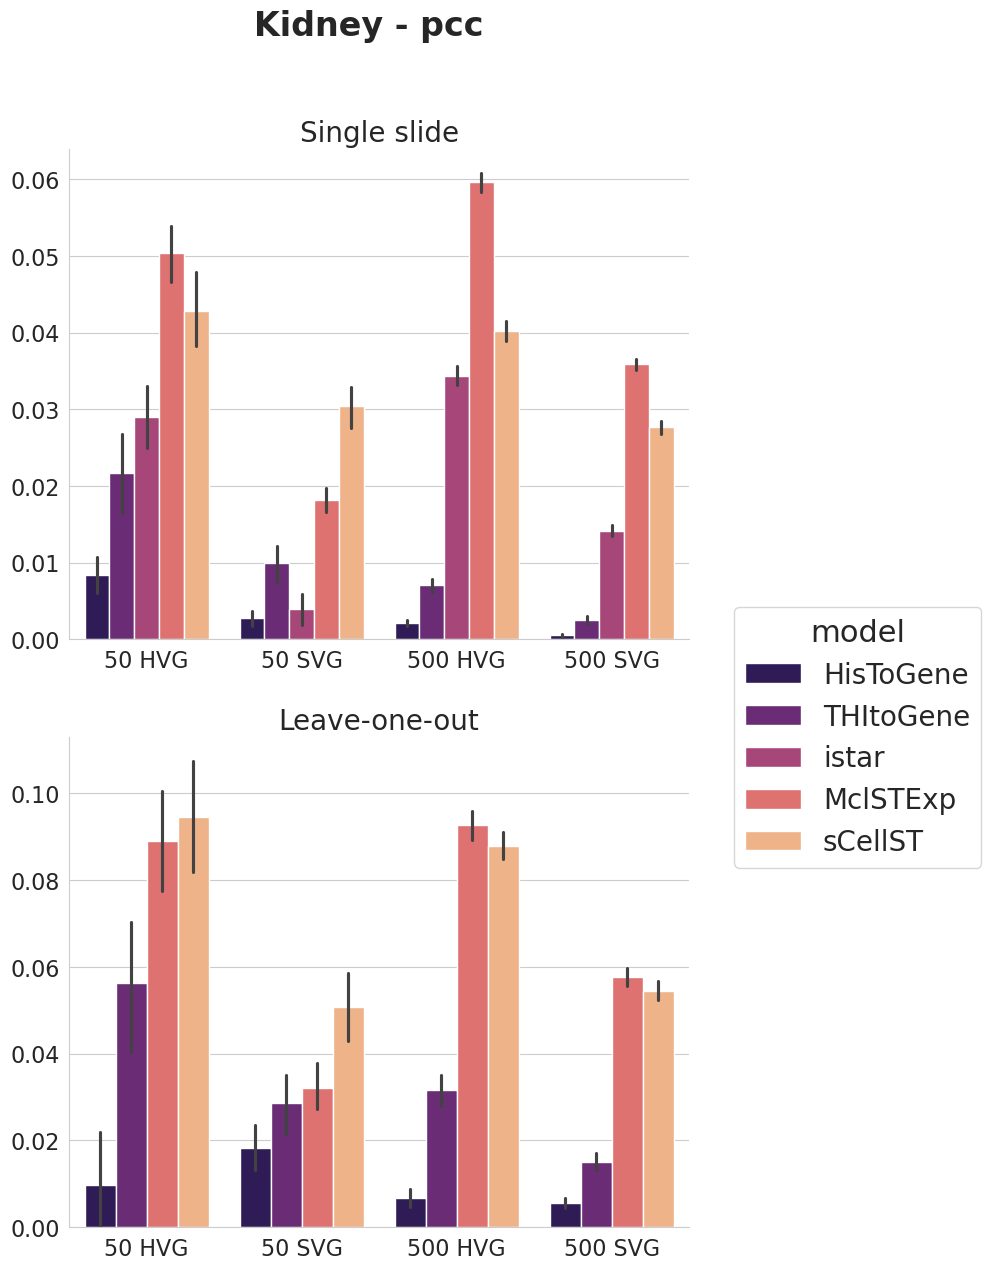

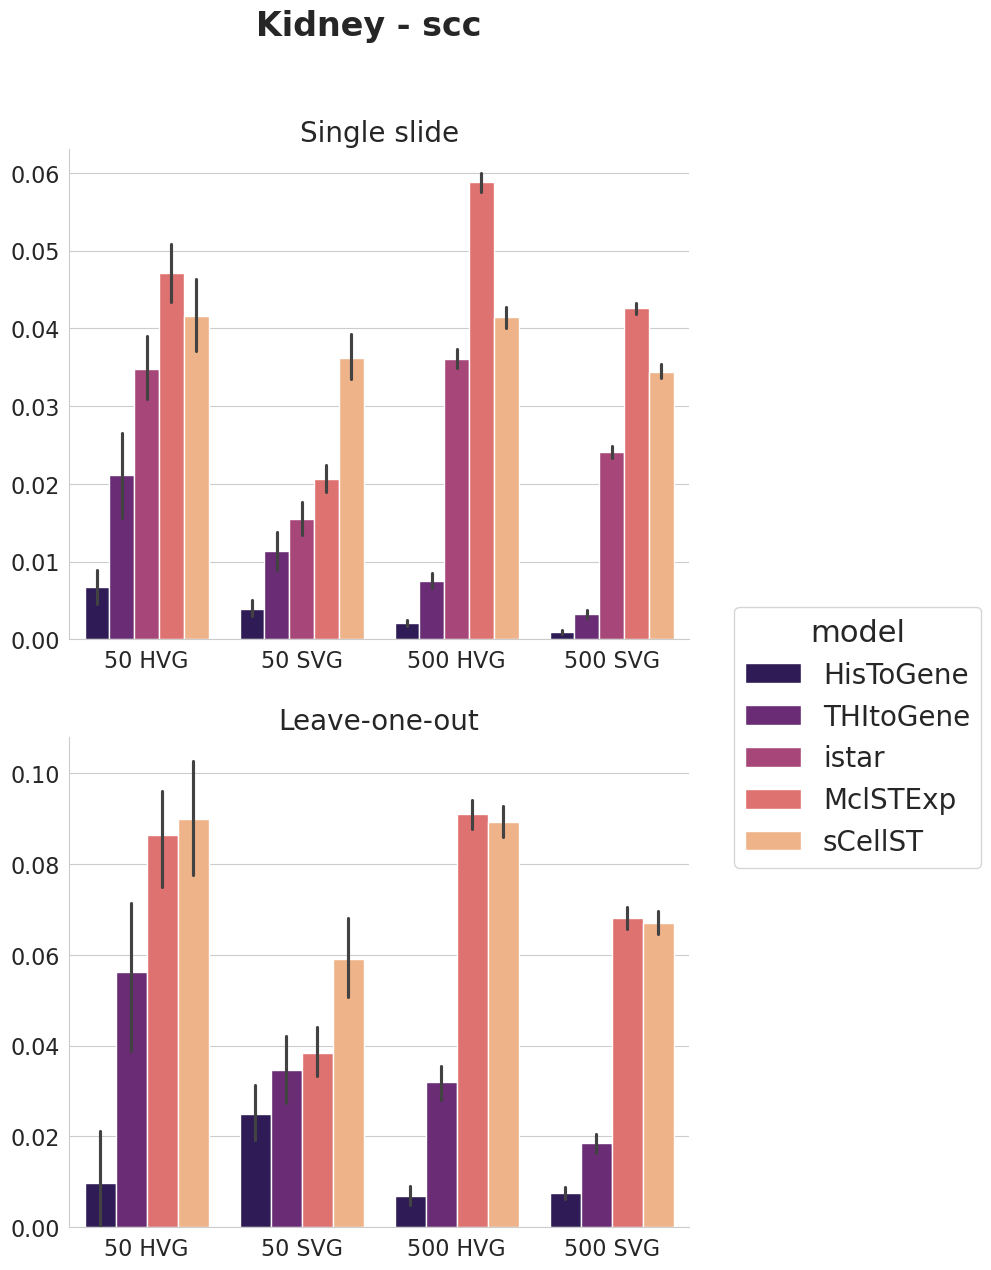

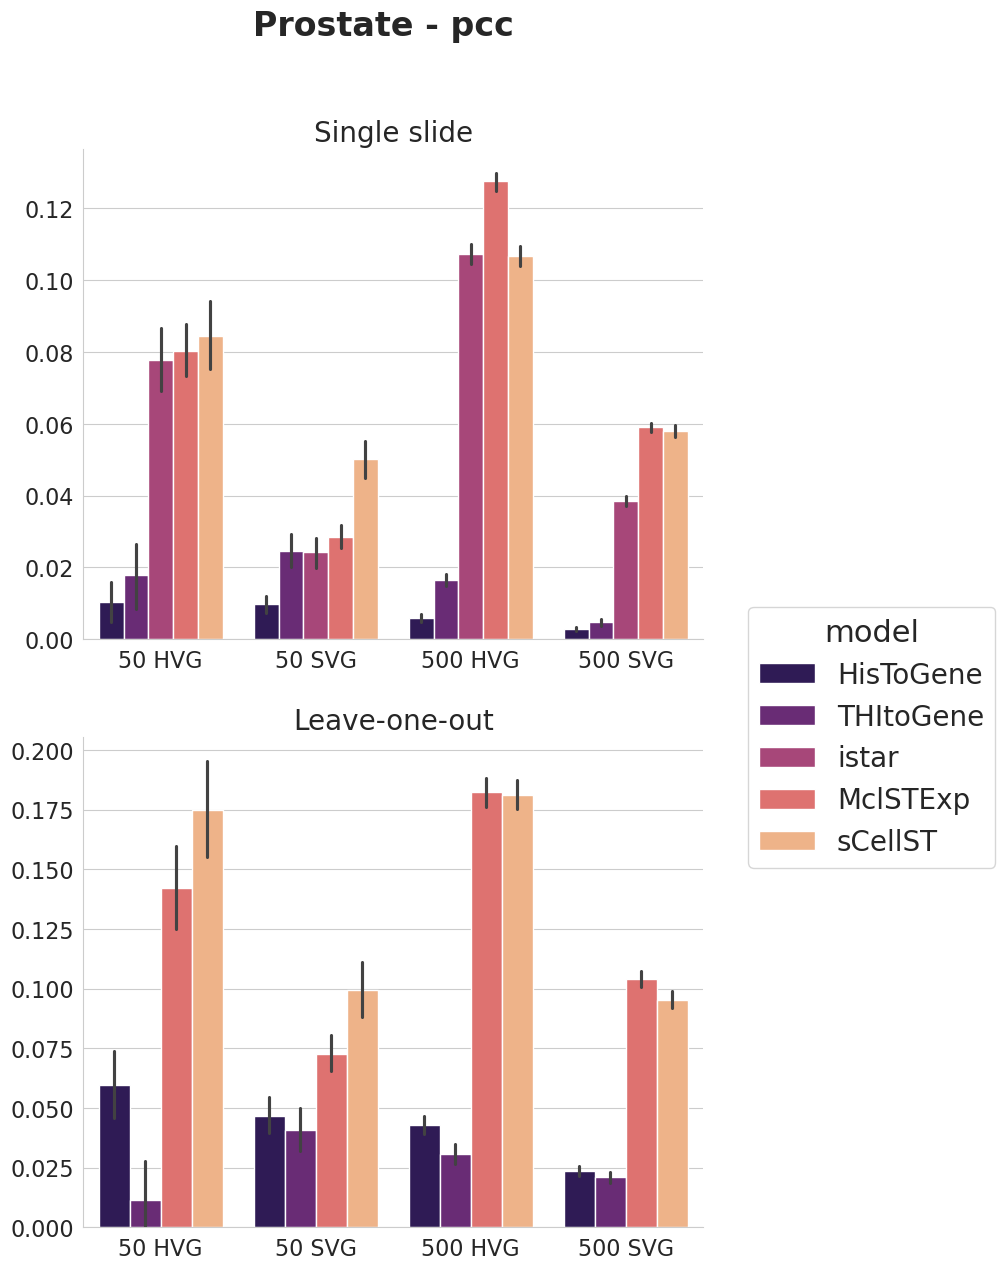

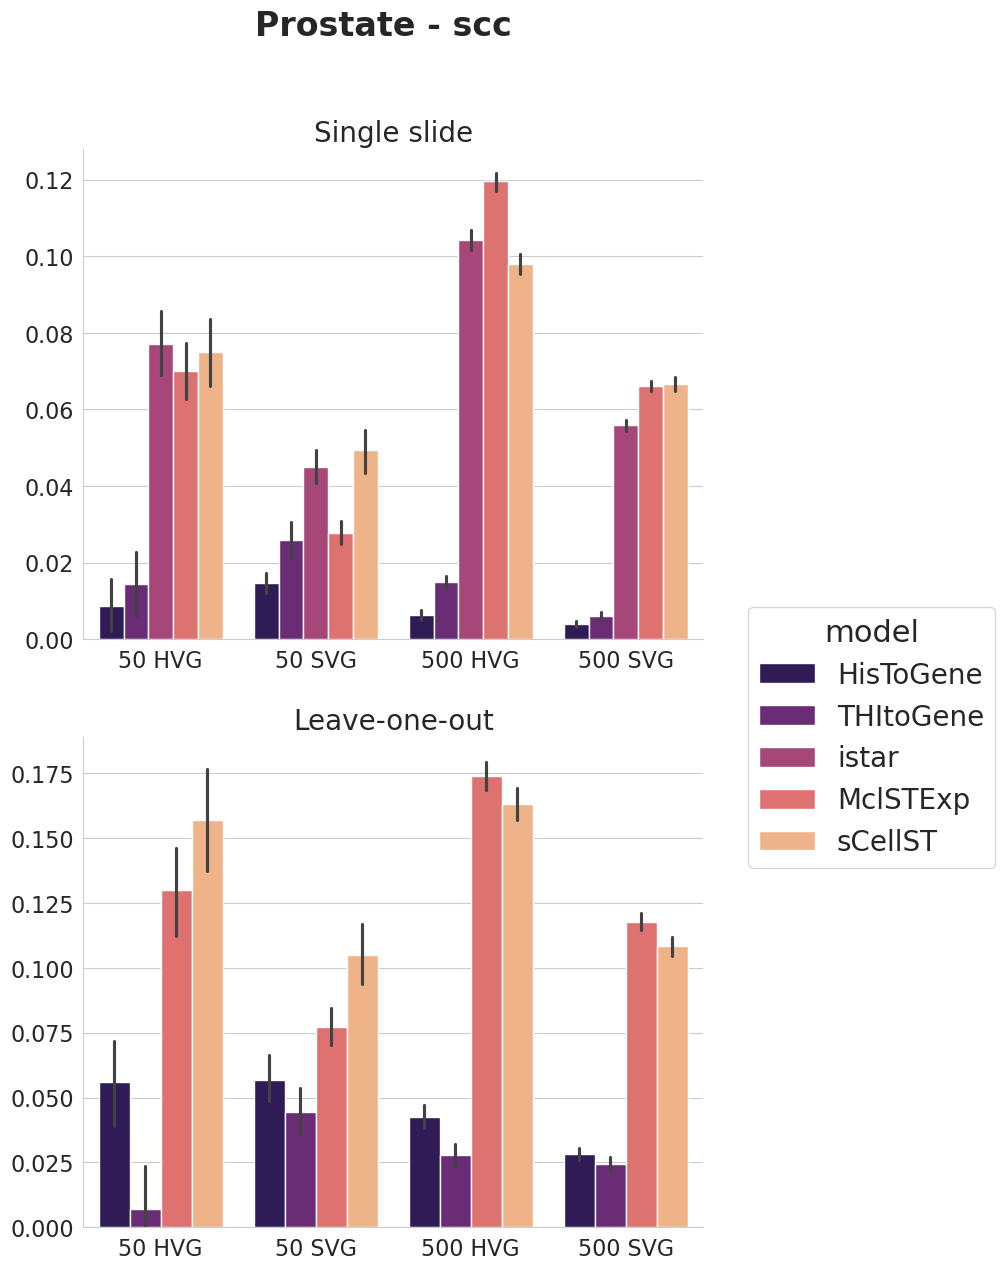

In [68]:
x_order = ["50 HVG", "50 SVG", "500 HVG", "500 SVG"]

for organ in metrics["organ"].unique():
    for metric in metrics_test:
        fig, axes = plt.subplots(2, 1, figsize=(8, 14))

        # Single slide plot
        df_plot = metrics.copy()
        df_plot = df_plot[
            ~metrics["multislide_training"]
            & (df_plot["train_slide"] != df_plot["test_slide"])
            & (df_plot["organ"] == organ)
        ]
        hue_order = ["HisToGene", "THItoGene", "istar", "MclSTExp", "sCellST"]

        sns.barplot(
            data=df_plot,
            x="genes",
            hue="model",
            y=metric,
            palette=palette,
            order=x_order,
            hue_order=hue_order,
            ax=axes[0],
        )
        axes[0].set_title(f"Single slide", fontsize=20)
        axes[0].set_xlabel("")
        axes[0].tick_params(axis='x', labelsize=16)
        axes[0].tick_params(axis='y', labelsize=16)
        axes[0].set_ylabel("")
        axes[0].set_ylim(0, None)
        sns.move_legend(axes[0], "center left", bbox_to_anchor=(1.05, - 0.2), fontsize=20, title_fontsize=22)
        sns.despine(fig)

        # Multi slide plot
        df_plot = metrics.copy()
        df_plot =  metrics[
            (metrics["multislide_training"]) & (metrics["organ"] == organ)
        ].copy()
        df_plot["test_slide_fold"] = df_plot["test_slide"].factorize(sort=True)[0]
        df_plot = df_plot[(df_plot["test_slide_fold"] == df_plot["fold"].astype(int))]

        hue_order = ["HisToGene", "THItoGene", "MclSTExp", "sCellST"]
        sns.barplot(
            data=df_plot,
            x="genes",
            hue="model",
            y=metric,
            palette=palette,
            order=x_order,
            hue_order=hue_order,
            legend=False,
            ax=axes[1],
        )
        axes[1].set_title("Leave-one-out", fontsize=20)
        axes[1].set_xlabel("")
        axes[1].tick_params(axis='x', labelsize=16)
        axes[1].tick_params(axis='y', labelsize=16)
        axes[1].set_ylabel("")
        axes[1].set_ylim(0, None)
        sns.despine(fig)

        fig.suptitle(f"{organ} - {metric}", fontsize=24, fontweight="bold")
        fig.savefig(save_path / f"{organ}_{metric}.png", bbox_inches="tight")
        plt.show()

# 2. Thumbnail of all slides

In [ ]:
from scellst_reproducibility.submit_scripts.script_constants import visium_slides
import cv2

target_size = (500, 500)

images = {
   organ: [cv2.resize(cv2.cvtColor(cv2.imread(f"../hest_data/thumbnails/{slide}_downscaled_fullres.jpeg"),cv2.COLOR_BGR2RGB), target_size) for slide in slides] for organ, slides in visium_slides.items()
}

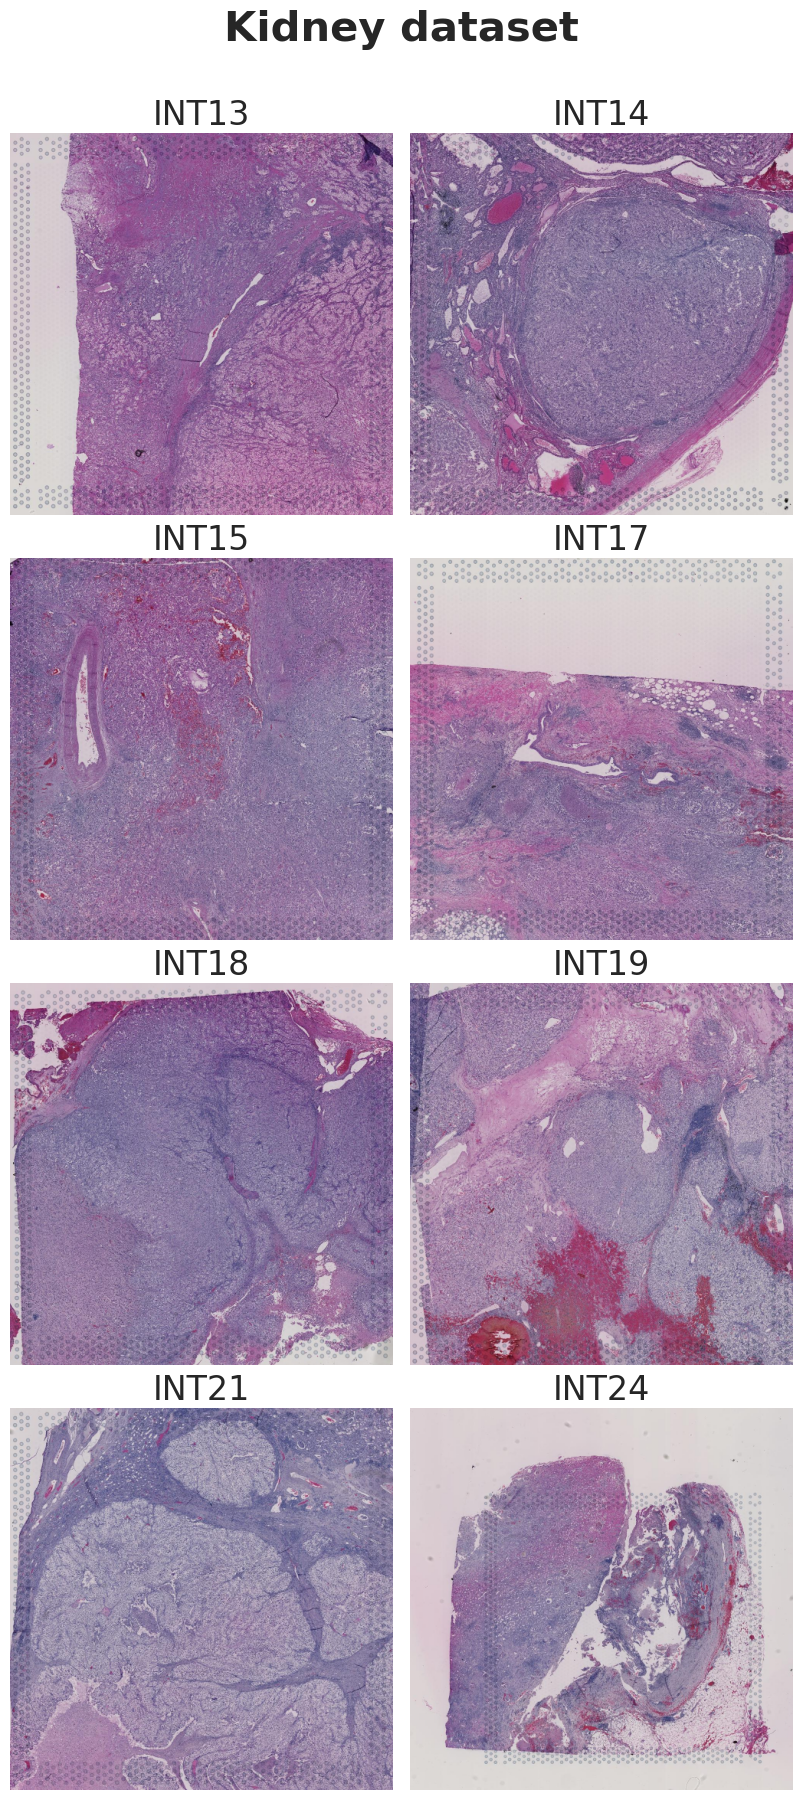

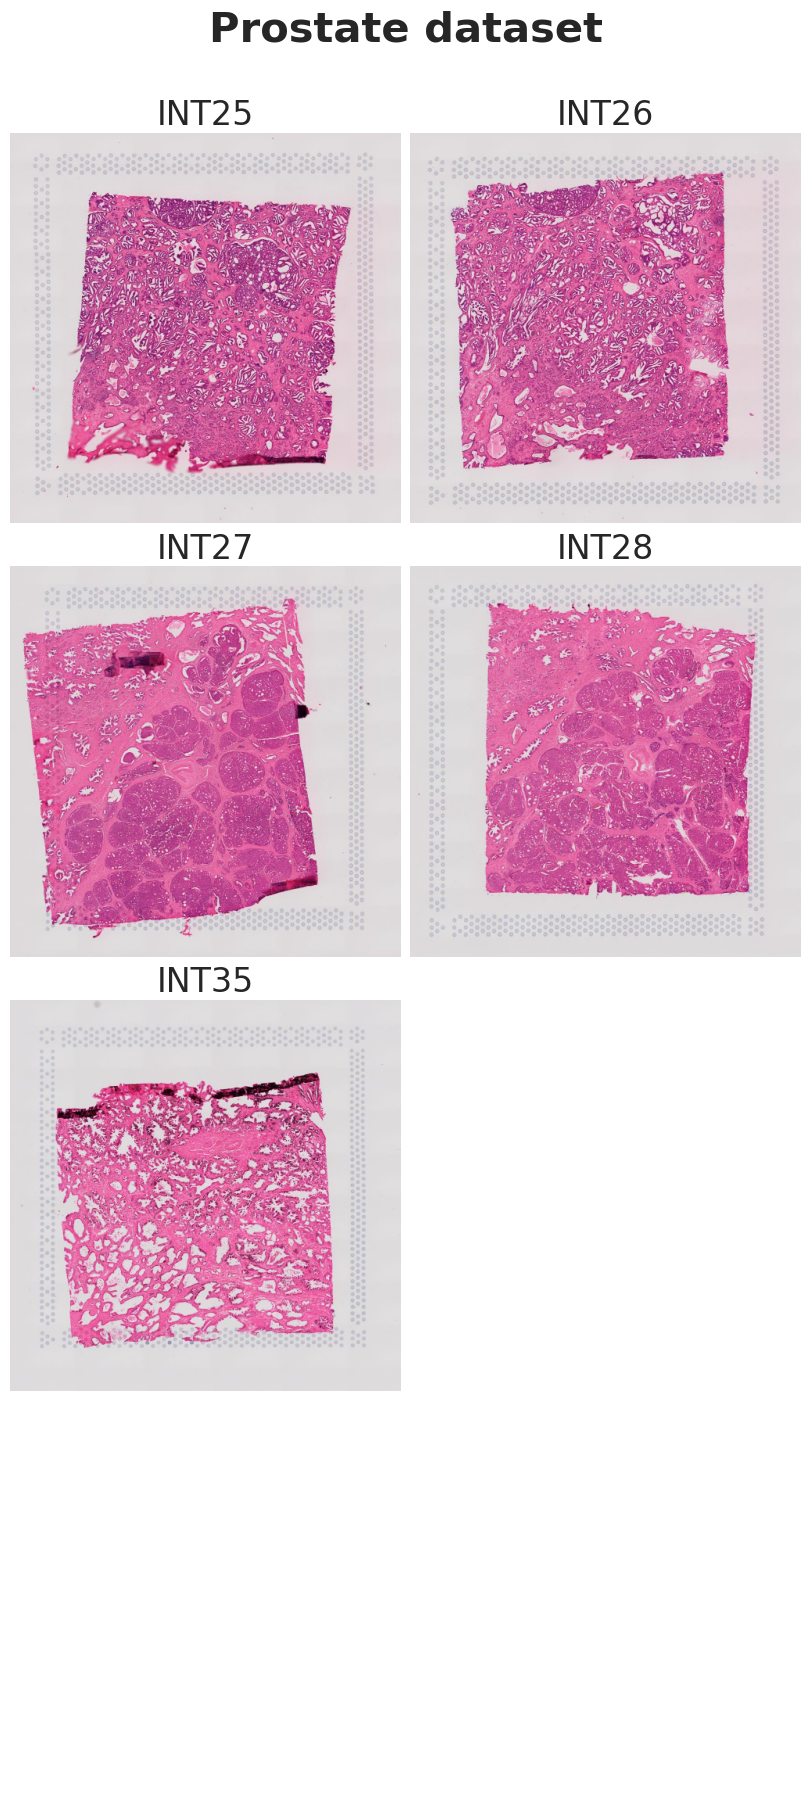

In [58]:
for organ in visium_slides.keys():
    fig, axes = plt.subplots(4, 2, figsize=(8., 17), constrained_layout=True)

    for ax, (img, name) in zip(axes.flatten(), zip(images[organ], visium_slides[organ])):
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(name, fontsize=24)

    # Remove empty axes
    for ax in axes.flatten()[len(visium_slides[organ]):]:
        ax.axis("off")
        # remove grid
        ax.grid(False)

    fig.suptitle(f"{organ} dataset", fontsize=30, fontweight="bold", y=1.05, ha="center")
    fig.savefig(save_path / f"{organ}_thumbnails.png", bbox_inches="tight")